# Neural Process example implementation for Mixture Density Learning

In [1]:
# %load_ext autoreload
# %autoreload 2

In [24]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
import jax
import jax.numpy as jnp
import jax.tree_util
import pickle
from torch.utils.data import Dataset
from torch.utils.data import Subset

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

cuda? [cuda(id=0)] NVIDIA GeForce GTX 1050


In [3]:
# Test-configuration
dataset_size = 128
test_resolution = 512

model , params = create_model(rng)
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

/tmp/ipykernel_19056/861604069.py:6: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


In [4]:
# Train-configuration
num_posterior_mc = 3  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 32
num_context_samples = 64

## Define Training Distribution/ Data-Generation

In [5]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [6]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

<Axes: xlabel='None', ylabel='None'>

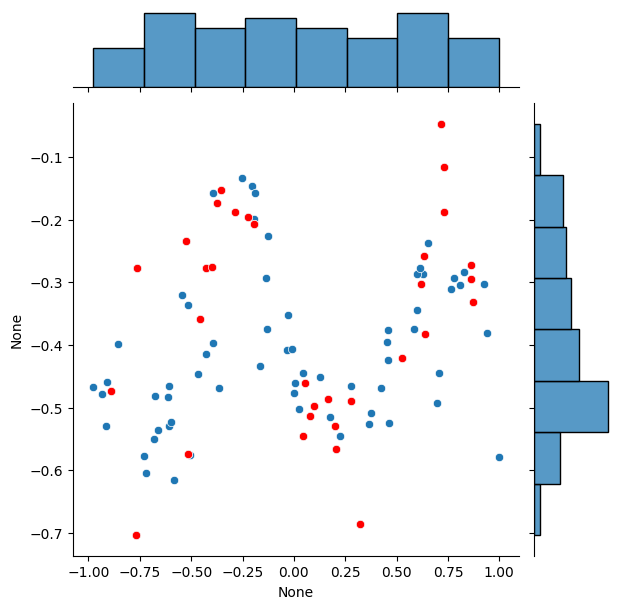

In [7]:
# Specify which function-prior to learn
# data_sampler = partial(
#     joint, 
#     Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
#     partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
# )
data_sampler = partial(
    joint, 
    WhiteNoise(f2, 0.1), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

rng, key = jax.random.split(rng)
xs, ys = data_sampler(key)

X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))

sns.jointplot(x=xs, y=ys)
sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

## Define Test-Case

(128,) (128,) (128, 1) (128, 1) (125, 1)


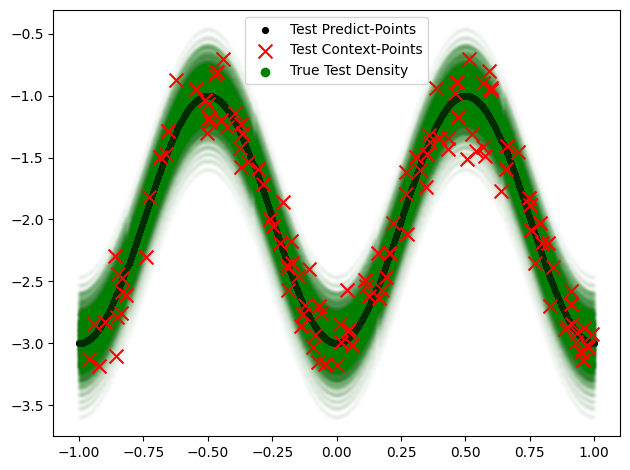

In [8]:

# def f(
#     key: flax.typing.PRNGKey, 
#     x: jax.Array, 
#     noise_scale: float = 0.2, 
#     mixture_prob: float = 0.5, 
#     corrupt: bool = True
# ):
#     key_noise, key_mixture = jax.random.split(key)
    
#     noise = jax.random.normal(key, x.shape) * noise_scale
#     choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

#     # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
#     return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise



rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)


print(xs.shape, ys.shape, xs[..., None].shape, ys[..., None].shape, xs[3:, None].shape)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

# Define the Model

In [9]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_util.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

In [34]:
checkpoint_dir = './trained_model_params/'

os.makedirs(checkpoint_dir, exist_ok=True)
with open(os.path.join(checkpoint_dir, 'model_param_1.pkl'), 'wb') as f:
    pickle.dump(params, f)


with open (os.path.join(checkpoint_dir, 'model_param_1.pkl'), 'rb') as f:
    loaded_params = pickle.load(f)

print('loaded_params', loaded_params)

loaded_params {'params': {'embed_xs': {'Dense_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[-0.77496946,  0.13366136,  0.46664956,  0.05639048,  2.0088127 ,
         0.06695865,  0.15504472, -1.7996286 ,  0.40663484,  2.126789  ,
        -1.5563511 ,  1.0003486 , -1.9592423 ,  0.3063073 , -1.5259129 ,
         0.38620657, -0.00469516, -1.5748763 , -0.759464  ,  1.2488995 ,
        -0.502628  , -1.0985146 , -0.07208785,  1.1488441 ,  1.9066732 ,
        -0.9765203 ,  0.01871129,  1.2397215 , -0.43316877, -0.9085376 ,
         0.5943316 ,  0.6627663 ,  1.3604758 , -1.8202804 ,  0.04104223,
        -0.7956212 , -0.61719996,  1.1579524 , -1.4817092 ,  0.28548726,
         0.7945917 , -0.14303412,  0.38349557,

# Dummy Optimization/ Amortization procedure

In [10]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


In [11]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState, 
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    # value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [12]:
def body(carry, x):
    params, opt_state, key = carry

    key_carry, key_step = jax.random.split(key)
    params, opt_state, value = step(params, opt_state, key_step)

    return (params, opt_state, key_carry), value


@partial(jax.jit, static_argnums=3)
def scan_train(params, opt_state, key, num: int):
    
    last, out = jax.lax.scan(body, (params, opt_state, key), xs=None, length=num)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [38]:
scan_chunk = 100

# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10_000 // scan_chunk, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key, scan_chunk)

    losses.append(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses).ravel()

Array((), dtype=key<fry>) overlaying:
[1047451582 4024857078]


Optimizing params. :   0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

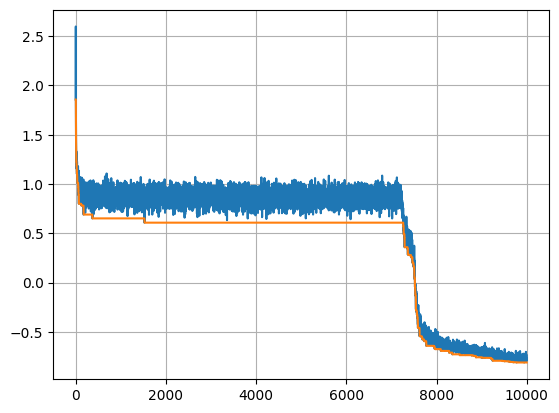

In [15]:
losses = jnp.asarray(losses).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

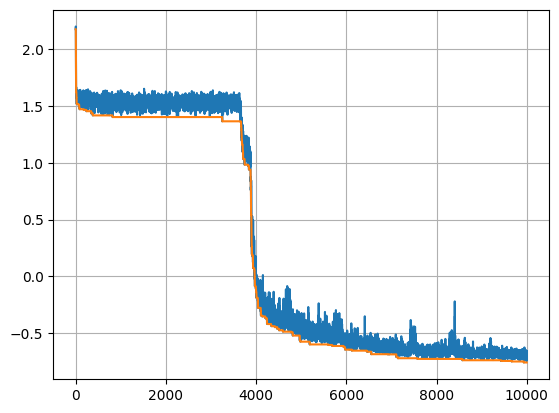

In [24]:
# Using q40 filtering

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

In [13]:


def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    key_data, key_model = jax.random.split(key)
    


    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()

@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value



In [14]:
def body_batch(carry, batch):
    params, opt_state, key = carry
    key_carry, key_step = jax.random.split(key)

    X, x_test = jnp.split(batch[0], indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(batch[1], indices_or_sections=(num_context_samples, ), axis=1)
    params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step)

    return (params, opt_state, key_carry), value

@jax.jit
def scan_train(params, opt_state, key, batches):
    
    last, out = jax.lax.scan(body_batch, (params, opt_state, key), batches)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [15]:
class RegressionDataset(Dataset):
    def __init__(self, dataset):
        self.x , self.y = dataset
    def __len__(self):
        return  self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def _get_data(self):

        return self.x, self.y

In [75]:
# Lets setup the spl for a very small example so we can debug and make sure it would work on a basic level

# We have to setup the dataset + dataloader
# Create a SPL_curricula class to encapsulate a dataset, and the ordering , pacing logic
# For now lets hard code, the hard weight variant, with a linear pacing function, understood as portion of data being sampled


@partial(jax.jit, static_argnums=0)
def per_sample_loss(part_func, key_loss,X, y, x_test, y_test):
    return part_func(X, y, x_test, y_test, rngs={'default': key_loss})

class SPL_curriculum:
    def __init__(self, start_rate, growth_epochs, dataset, batch_size, rng):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_epochs= growth_epochs 
        self.dataset = dataset
        self.rng = rng
        self.weight_log = []




    def data_curriculum(self, loss_partial, epoch):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0
        if(epoch == 0):
            data_rate = self.start_rate

        else:

            data_rate =  min(1.0 , self.start_rate + (1.0 - self.start_rate) / self.growth_epochs * epoch)

        
        curr_data_size = int(data_rate * self.dataset.__len__())
        print('curr_data_size', curr_data_size, "curr_data_rate", data_rate, "epoch number" , epoch) 

        losses = self.calculate_difficulty_ordering(loss_partial)
        sorted_indices = jnp.argsort(losses)[:curr_data_size]
        print('sorted indices shape', sorted_indices.shape)
        self.weight_log.append(sorted_indices)

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True, drop_last=True)  # Maybe shuffle? 
        # calculate the loss over the dataset with the current model and params
    
    def calculate_difficulty_ordering(self,loss_partial):

        """ Calculate the difficulty of the dataset based on the model and params
        """
        chunk_size = self.batch_size
        # currently problem since self.dataset._get_data() returns tuple of 4 arrays, but we need to return a tuple of 4 arrays for each sample, so we need to do it in a different way
        

        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(partial(per_sample_loss, loss_partial), in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        xs , ys =self.dataset._get_data() 
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)
        losses = chunked_loss_f(key_losses, X, y, x_test,y_test) 
        return losses 





# Lets also setup the SepMeta implementation as it doesnt require argsort. 

class SPL_loss_curriculum():

    def __init__(self, start_rate, growth_pace, dataset, batch_size, rng, save_path):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_growth_pace = growth_pace 
        self.dataset = dataset
        self.rng = rng

        self.lambda_threshold= self.init_lambda(model, params)
        print('lambda threshold', self.lambda_threshold)
        self.weight_log = []
        # Initialize a memmap file for epoch indices


    def init_lambda(self, model, params):
        # lets compute the initial lambda, which is the loss value that would correspond to the start_rate thresholding

        losses = self.calculate_difficulty_ordering(model, params)
        losses_sorted = jnp.sort(losses)
        start_lambda = losses_sorted[int(self.start_rate * len(losses_sorted))]
        return start_lambda
    
    def data_curriculum(self, model, params, epoch ):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0


        losses = self.calculate_difficulty_ordering(model, params)

        lambda_threshold = self.lambda_threshold + self.growth_growth_pace * epoch

        sorted_indices = jnp.where(losses <= lambda_threshold)[0]
        print('sorted indices shape', sorted_indices.shape)

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True)
        # calculate the loss over the dataset with the current model and params
 

    def calculate_difficulty_ordering(self, model, params):

        """ Calculate the difficulty of the dataset based on the model and params
        """

        chunk_size = self.batch_size
        # currently problem since self.dataset._get_data() returns tuple of 4 arrays, but we need to return a tuple of 4 arrays for each sample, so we need to do it in a different way
        

        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(per_sample_loss, in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        X_b, y_b, x_test_b, y_test_b = self.dataset._get_data() 
        losses = chunked_loss_f(key_losses, X_b, y_b, x_test_b, y_test_b) 
        return losses 





In [76]:
# lets setup the training dataset and dataloader
# Trying out how to more efficiently produce the dataset 

@partial(jax.jit, static_argnums=(1,2))
def gen_sampler_datapoint(key, num_context_samples, sampler):
    x, y = sampler(key)
    x, y = x[..., None], y[..., None]

    return x,y 

@partial(jax.jit, static_argnums=(1,2,3,4))
def generate_dataset(rng , num_batches, num_context_samples, sampler, chunk_size):
    rng_old , key = jax.random.split(rng)
    keys = jax.random.split(rng, num_batches)
    # Apply the function in chunks using netket.jax.vmap_chunked
    batched_generate = nk.jax.vmap_chunked(
        partial(gen_sampler_datapoint, num_context_samples=num_context_samples, sampler=sampler),
        in_axes=0,
        chunk_size=chunk_size
    )
    x ,y  = batched_generate(keys)
    return  x,y 

def generate_noisy_split_trainingdata(samplers , sampler_ratios, dataset_size, chunk_size, num_context_samples, rng):
    """ Generate a dataset with a split of different samplers and ratios
    """

    keys = jax.random.split(rng, len(samplers))
    datasets = []
    for (sampler, ratio, key) in zip(samplers, sampler_ratios, keys):
        dataset = generate_dataset(key, int(dataset_size*ratio), num_context_samples, sampler, chunk_size)
        datasets.append(np.asarray(dataset))



    x_datasets, y_datasets = zip(*datasets)
    return  np.asarray((jnp.concatenate(x_datasets), jnp.concatenate(y_datasets)))
dataset_trial = generate_dataset(rng, 128*100, num_context_samples, data_sampler, 128)
print(dataset_trial[0].shape)


## Dataset generation 

dataset_size = 128*100

# Pytorch needs numpy array, tensor, list or dicts, so we have to keep converting back and forth between jnp and np stuff. But its fairly straightforwards just have to take care
dataset = RegressionDataset(np.asarray(generate_dataset(rng, dataset_size, num_context_samples, data_sampler,512 )))
# basic dataloader for now and then we move onto spl curriculum
dataset = RegressionDataset(generate_noisy_split_trainingdata([data_sampler, data_sampler], [0.5, 0.5], dataset_size, 512, num_context_samples, rng))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('dataset size', dataset.__len__())

batches = [batch for batch in dataloader]


batch = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), batches))

print(type(batch))

spl_curricula = SPL_curriculum(0.1, 5 , dataset, batch_size, key)

loss_calc_partial = partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo)

spl_batches = [batch for batch in spl_curricula.data_curriculum(loss_calc_partial, 0)]

spl_batch = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), spl_batches))


(12800, 96, 1)
dataset size 12800
<class 'jaxlib.xla_extension.ArrayImpl'>
curr_data_size 1280 curr_data_rate 0.1 epoch number 0


TypeError: Cannot interpret value of type <class 'networks.MixtureNeuralProcess'> as an abstract array; it does not have a dtype attribute

In [122]:
scan_chunk = dataset_size // batch_size

# Initialize the Optimization.
rng, key = jax.random.split(rng)

# create the regression dataset with the datasampler for now:

last_key = key
print(last_key)

data_sampler_noisy = partial(
    joint, 
    WhiteNoise(f2, 0.1), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

data_sampler_clean = partial(
    joint, 
    f2, 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)
data_sampler_mix = partial(
    joint,
    Mixture([WhiteNoise(f2, 0.1), f2]),
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)
    )
)

# lets setup the dataset generator
dataset_size = 128*100
chunk_size = 128
samplers = [data_sampler_noisy, data_sampler_clean]
sampler_ratios = [0.2, 0.8]

dataset = generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, num_context_samples, rng)
dataloader = DataLoader(RegressionDataset(dataset), batch_size=batch_size, shuffle=True )

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(100 ,desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    batches = [batch for batch in dataloader]
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key, jnp.asarray( batches))

    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[ 799645789 1885581747]


Optimizing params. Loss: 0.6442:   3%|▎         | 3/100 [01:25<46:05, 28.51s/it]


KeyboardInterrupt: 

In [20]:
scan_chunk = dataset_size // batch_size

# Initialize the Optimization.
rng, key = jax.random.split(rng)

# create the regression dataset with the datasampler for now:

last_key = key
print(last_key)
dataset = RegressionDataset(generate_noisy_split_trainingdata([data_sampler, data_sampler], [0.5, 0.5], dataset_size, 512, num_context_samples, rng))
spl_curricula = SPL_curriculum(0.1, 5 , dataset, batch_size, key)
params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    batches = jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in spl_curricula.data_curriculum(model, params, i)])
     
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key,jnp.asarray(batches))

    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses)

Array((), dtype=key<fry>) overlaying:
[1576056289 2410035865]


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 1280 curr_data_rate 0.1 epoch number 0
sorted indices shape (1280,)


Optimizing params. Loss: 1.6080:  10%|█         | 1/10 [00:08<01:12,  8.10s/it]

curr_data_size 3584 curr_data_rate 0.28 epoch number 1


Optimizing params. Loss: 1.6080:  10%|█         | 1/10 [00:12<01:55, 12.83s/it]


KeyboardInterrupt: 

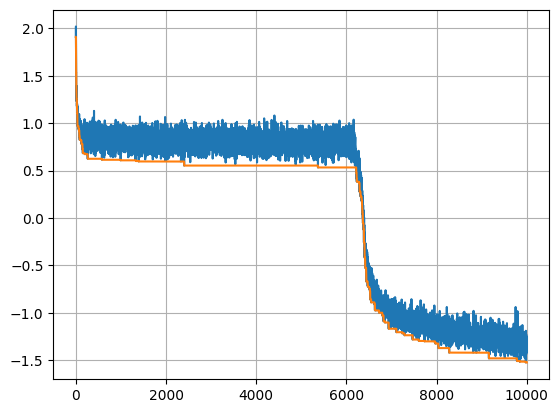

In [117]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

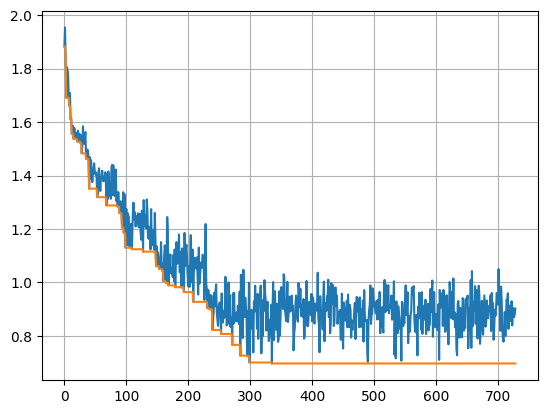

In [117]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

In [128]:
print(spl_curricula.weight_log)
for i in spl_curricula.weight_log:
    print(i.shape)

with open(os.path.join("./spl_metadata/", 'spl_curricula_weight.pkl'), 'wb') as f:
    pickle.dump(spl_curricula.weight_log, f)

with open(os.path.join("./spl_metadata/", 'spl_curricula_weight.pkl'), 'rb') as f:
    loaded = pickle.load(f)


for i in loaded:
    print(i.shape)

[Array([ 7079, 10199, 11705, ...,  3887,  7542,  5087], dtype=int64), Array([12323,  8099,  4474, ...,  5704,  1449,  6460], dtype=int64), Array([11753,  9111,   994, ...,  3660,  8890,  9463], dtype=int64)]
(1280,)
(3584,)
(5888,)
(1280,)
(3584,)
(5888,)


In [53]:
# lets setup the training dataset and dataloader
# Trying out how to more efficiently produce the dataset 

@partial(jax.jit, static_argnums=(1,2))
def gen_sampler_datapoint(key, num_context_samples, sampler):
    x, y = sampler(key)
    x, y = x[..., None], y[..., None]

    return x,y 

@partial(jax.jit, static_argnums=(1,2,3,4))
def generate_dataset(rng , num_batches, num_context_samples, sampler, chunk_size):
    rng_old , key = jax.random.split(rng)
    keys = jax.random.split(rng, num_batches)
    # Apply the function in chunks using netket.jax.vmap_chunked
    batched_generate = nk.jax.vmap_chunked(
        partial(gen_sampler_datapoint, num_context_samples=num_context_samples, sampler=sampler),
        in_axes=0,
        chunk_size=chunk_size
    )
    x ,y  = batched_generate(keys)
    return  x ,y


dataset_trial = generate_dataset(rng, 128*100, num_context_samples, data_sampler, 128)
print(dataset_trial[0].shape)


(12800, 96, 1)


In [57]:
# lets setup a split ratio dataset generator with different sampler and ratio options

def generate_noisy_split_trainingdata(samplers , sampler_ratios, dataset_size, chunk_size, num_context_samples, rng):
    """ Generate a dataset with a split of different samplers and ratios
    """

    keys = jax.random.split(rng, len(samplers))
    datasets = []
    for (sampler, ratio, key) in zip(samplers, sampler_ratios, keys):
        dataset = generate_dataset(key, int(dataset_size*ratio), num_context_samples, sampler, chunk_size)
        datasets.append(dataset)



    x_datasets, y_datasets = zip(*datasets)
    return  jnp.concatenate(x_datasets), jnp.concatenate(y_datasets)


# lets setup a noisy and non noisy sampler

data_sampler_noisy = partial(
    joint, 
    WhiteNoise(f2, 0.1), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

data_sampler_clean = partial(
    joint, 
    f2, 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

# lets setup the dataset generator
dataset_size = 128*100
chunk_size = 256 
samplers = [data_sampler_noisy, data_sampler_clean]
sampler_ratios = [0.5, 0.5]

dataset = generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, num_context_samples, rng)


# lets check if with the same rng key we get the same noisy split data as well. 

new_rng1 = jax.random.PRNGKey(0)
new_rng2 = jax.random.PRNGKey(0)

dataset1 = generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, num_context_samples, new_rng1)
dataset2 = generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, num_context_samples, new_rng2)

print(jnp.all(dataset1[0] == dataset2[0]), jnp.all(dataset1[1]==dataset2[1]))


True True


In [49]:
def train_spl_curriculum(dataset_key_int, dataset_size, training_step_number, sampler_ratios, chunk_size, save_path ,  model_name, start_rate, growth_epochs):

    os.makedirs(save_path, exist_ok=True)
    num_context_samples = 64
    num_target_samples = 32
    batch_size = 128
    kl_penalty = 1e-4
    num_posterior_mc = 1


    # First lets create the dataset, 
    # Lets hardcode it for now, and then we can make it more flexible later on
    
    sampler_noise = partial(
        joint, 
        WhiteNoise(f2, 0.1), 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    sampler_clean = partial(
        joint, 
        f2, 
        partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
    )

    samplers = [sampler_noise, sampler_clean]

    dataset_key = jax.random.PRNGKey(dataset_key_int)
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, num_context_samples, dataset_key))

    # Lets setup the SPL curriculum

    rng , curricula_key = jax.random.split(dataset_key)
    spl_curricula = SPL_curriculum(start_rate, growth_epochs , dataset, batch_size, curricula_key)



    # Lets initalize the model we are going to train

    rng, key = jax.random.split(rng)

    model , params = create_model(key)
    optimizer = optax.chain(
        optax.clip(.1),
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
    )
    opt_state = optimizer.init(params)

    best, best_params = jnp.inf, params
    losses = list()

    for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):
        
        rng, key = jax.random.split(rng)
        
        batches = jnp.asarray( jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in spl_curricula.data_curriculum(model, params, i)]))
        # params_new, opt_state, loss = step(params, opt_state, key)
        params_new, opt_state, loss_arr = scan_train(params, opt_state, key,batches)

        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params_new
        
        if jnp.isnan(loss_arr).any():
            break
        else:
            params = params_new
        
        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

    # Lets save what we need to save for the model and training. 

    ### After training we should save  
        # the model parameters with a name that we know how it was trained
        # the losses and other relevant information accrued during training
        # the curriculum weight log for the dataset

    # Saving the model params
    # We could also save opt_state here for later training
    #Also after trying out whether the training would continue saving and loading the params back in I saw change in printed loss. Not sure why that is the case,
    # Even if I restore the opt_state as well. Regardless, the model continue training so saving the params is enough to use the model for evaluation later on. 
    
    save_model_params(best_params,save_path, model_name) 
    
    with open(os.path.join(save_path, model_name + '_curricula_weights.pkl'), 'wb') as f:
        if(len(spl_curricula.weight_log)>0):
            pickle.dump(spl_curricula.weight_log, f)
    
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump(losses, f)






In [50]:
train_spl_curriculum(0, 128*10, 10, [0.3,0.7], 128, "./spl_training_data/", "spl_model_0", 0.1, 5)

Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0
sorted indices shape (128,)


Optimizing params. Loss: 2.1381:  10%|█         | 1/10 [00:01<00:13,  1.49s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1
sorted indices shape (358,)


Optimizing params. Loss: 1.8731:  20%|██        | 2/10 [00:03<00:12,  1.61s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2
sorted indices shape (588,)


Optimizing params. Loss: 1.5927:  30%|███       | 3/10 [00:05<00:12,  1.83s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3
sorted indices shape (819,)


Optimizing params. Loss: 1.4125:  40%|████      | 4/10 [00:07<00:12,  2.08s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4
sorted indices shape (1049,)


Optimizing params. Loss: 1.2831:  50%|█████     | 5/10 [00:10<00:11,  2.36s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5
sorted indices shape (1279,)


Optimizing params. Loss: 1.1607:  60%|██████    | 6/10 [00:13<00:10,  2.62s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6
sorted indices shape (1280,)


Optimizing params. Loss: 1.0230:  70%|███████   | 7/10 [00:16<00:08,  2.83s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7
sorted indices shape (1280,)


Optimizing params. Loss: 1.0091:  80%|████████  | 8/10 [00:20<00:05,  2.97s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8
sorted indices shape (1280,)


Optimizing params. Loss: 0.9170:  90%|█████████ | 9/10 [00:23<00:03,  3.07s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9
sorted indices shape (1280,)


Optimizing params. Loss: 0.9307: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


(128,)
(358,)
(588,)
(819,)
(1049,)
(1279,)
(1280,)
(1280,)
(1280,)
(1280,)
-------
prediction-shape (512, 1, 1) (512, 1, 1)


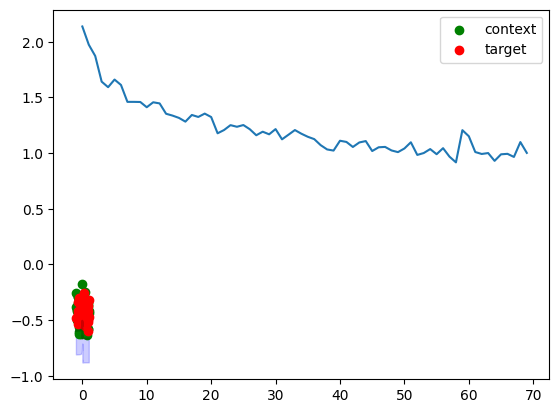

In [54]:
# Lets check if the necessary savings happened well

# Firstly lets check the weight logs

with open(os.path.join("./spl_training_data/", 'spl_model_0_curricula_weights.pkl'), 'rb') as f:
    loaded = pickle.load(f)

for i in loaded:
    print(i.shape)

print("-------")

# Now lets check the model params

saved_model_params = load_model_params("./spl_training_data/", "spl_model_0")

# Lets calculate some predictions with the loaded in params. 

model, _ = create_model(jax.random.PRNGKey(0))

rng, test_key = jax.random.split(rng)
# Test predictions on functions from the training-distribution
key_data, key_model = jax.random.split(test_key)

x_train, y_train = data_sampler(test_key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(num_context_samples, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(num_context_samples, ))


means, stds = model.apply(
    saved_model_params, 
    X, y, x_test[..., None],
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()




## Finally lets check if the training metrics have been saved 

with open(os.path.join("./spl_training_data/", 'spl_model_0_training_metrics.pkl'), 'rb') as f:
    loaded_metrics = pickle.load(f)


plt.plot(loaded_metrics)